## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
from shapely.geometry import Point, Polygon
import geopandas as gpd

%matplotlib inline

## Importing dataset

In [2]:
# data from http://data.torontopolice.on.ca/datasets/mci-2014-to-2019

crime = pd.read_csv('MCI_2014_to_2019.csv', parse_dates=['occurrencedate', 'reporteddate'])
crime.head()

,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,...,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Long,Lat,ObjectId
0,-79.405228,43.656982,7801,GO-20152165447,2015-12-18 03:58:00+00:00,2015-12-18 03:59:00+00:00,Commercial,1430,100,Assault,...,352.0,Friday,3,Assault,D14,79,University (79),-79.405228,43.656982,7001
1,-79.307907,43.778732,7802,GO-20151417245,2015-08-15 21:45:00+00:00,2015-08-17 22:11:00+00:00,Commercial,1430,100,Assault,...,227.0,Saturday,21,Assault,D42,118,Tam O'Shanter-Sullivan (118),-79.307907,43.778732,7002
2,-79.225029,43.765942,7803,GO-20151421107,2015-08-16 16:00:00+00:00,2015-08-18 14:40:00+00:00,Apartment,2120,200,B&E,...,228.0,Sunday,16,Break and Enter,D43,137,Woburn (137),-79.225029,43.765942,7003
3,-79.140823,43.778648,7804,GO-20152167714,2015-11-26 13:00:00+00:00,2015-12-18 13:38:00+00:00,Other,2120,200,B&E,...,330.0,Thursday,13,Break and Enter,D43,133,Centennial Scarborough (133),-79.140823,43.778648,7004
4,-79.288361,43.691235,7805,GO-20152169954,2015-12-18 19:50:00+00:00,2015-12-18 19:55:00+00:00,Commercial,1430,100,Assault,...,352.0,Friday,19,Assault,D55,61,Taylor-Massey (61),-79.288361,43.691235,7005


## Data cleaning

In [3]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206435 entries, 0 to 206434
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   X                    206435 non-null  float64            
 1   Y                    206435 non-null  float64            
 2   Index_               206435 non-null  int64              
 3   event_unique_id      206435 non-null  object             
 4   occurrencedate       206435 non-null  datetime64[ns, UTC]
 5   reporteddate         206435 non-null  datetime64[ns, UTC]
 6   premisetype          206435 non-null  object             
 7   ucr_code             206435 non-null  int64              
 8   ucr_ext              206435 non-null  int64              
 9   offence              206435 non-null  object             
 10  reportedyear         206435 non-null  int64              
 11  reportedmonth        206435 non-null  object             
 12  re

In [4]:
crime.columns

Index(['X', 'Y', 'Index_', 'event_unique_id', 'occurrencedate', 'reporteddate',
       'premisetype', 'ucr_code', 'ucr_ext', 'offence', 'reportedyear',
       'reportedmonth', 'reportedday', 'reporteddayofyear',
       'reporteddayofweek', 'reportedhour', 'occurrenceyear',
       'occurrencemonth', 'occurrenceday', 'occurrencedayofyear',
       'occurrencedayofweek', 'occurrencehour', 'MCI', 'Division', 'Hood_ID',
       'Neighbourhood', 'Long', 'Lat', 'ObjectId'],
      dtype='object')

Based on the data, we could do the following analyses:
- MCI trends over time, using occurrence dates
- Top crimes by neigborhoods
- Top crimes by premises
- Average hourly crimes
- Speed of reporting crimes (occurence minus report times)


With `event_unique_id` < total rows, some events entail more than one crime committed.

In [5]:
total = crime.isnull().sum().sort_values(ascending=False)
percent = round(crime.isnull().sum()/crime.isnull().count(), 4).sort_values(ascending=False)
null_data = pd.concat([total, percent], axis=1, keys=['Total', '%'])
null_data.head()

,Total,%
occurrencedayofweek,59,0.0003
occurrencedayofyear,59,0.0003
occurrenceday,59,0.0003
occurrencemonth,59,0.0003
occurrenceyear,59,0.0003


In [6]:
test = crime[['ucr_code', 'ucr_ext', 'MCI', 'offence']]
test.drop_duplicates(['ucr_code', 'ucr_ext', 'MCI', 'offence']).sort_values('ucr_code', ascending=True).reset_index(drop=True)

,ucr_code,ucr_ext,MCI,offence
0,1410,100,Assault,Aggravated Assault
1,1410,110,Assault,Aggravated Assault Avails Pros
2,1420,110,Assault,Assault Bodily Harm
3,1420,100,Assault,Assault With Weapon
4,1430,110,Assault,Assault - Force/Thrt/Impede
5,1430,100,Assault,Assault
6,1440,100,Assault,Unlawfully Causing Bodily Harm
7,1450,120,Assault,Discharge Firearm With Intent
8,1450,110,Assault,Air Gun Or Pistol: Bodily Harm
9,1450,100,Assault,Discharge Firearm - Recklessly


Seems like `ucr_code` and `ucr_ext` correspond to certain offences, which is confirmed by this website: https://www.justice.gc.ca/eng/rp-pr/csj-sjc/crime/rr06_fv3-rr06_vf3/c.html


We can now drop both these columns.

In [7]:
crime.dropna(inplace=True)

In [8]:
indexes = crime[crime['occurrenceyear'] < 2014 ].index
crime.drop(indexes , inplace=True)
crime = crime.drop(['X', 'Y', 'Index_', 'ucr_code', 'ucr_ext', 'Division', 'Hood_ID'], axis=1)

In [9]:
crime.astype({'occurrenceyear': 'object', 'occurrenceday': 'object', 'occurrencedayofyear': 'object','occurrencehour': 'object'\
    ,'reportedyear': 'object', 'reportedday': 'object', 'reporteddayofyear': 'object','reportedhour': 'object'}).dtypes

event_unique_id                     object
occurrencedate         datetime64[ns, UTC]
reporteddate           datetime64[ns, UTC]
premisetype                         object
offence                             object
reportedyear                        object
reportedmonth                       object
reportedday                         object
reporteddayofyear                   object
reporteddayofweek                   object
reportedhour                        object
occurrenceyear                      object
occurrencemonth                     object
occurrenceday                       object
occurrencedayofyear                 object
occurrencedayofweek                 object
occurrencehour                      object
MCI                                 object
Neighbourhood                       object
Long                               float64
Lat                                float64
ObjectId                             int64
dtype: object

In [10]:
crime.describe()

,reportedyear,reportedday,reporteddayofyear,reportedhour,occurrenceyear,occurrenceday,occurrencedayofyear,occurrencehour,Long,Lat,ObjectId
count,205321.000000,205321.000000,205321.000000,205321.000000,205321.000000,205321.000000,205321.000000,205321.000000,205321.000000,205321.000000,205321.000000
mean,2016.626833,15.748711,187.394451,12.832345,2016.607035,15.546023,186.552579,12.576775,-79.395038,43.707322,103442.914008
std,1.714717,8.769403,103.537580,6.590369,1.712493,8.882357,103.724321,7.208911,0.104335,0.052708,59529.625293
min,2014.000000,1.000000,1.000000,0.000000,2014.000000,1.000000,1.000000,0.000000,-79.639267,43.587093,1.000000
25%,2015.000000,8.000000,100.000000,8.000000,2015.000000,8.000000,99.000000,7.000000,-79.471481,43.661152,52046.000000
50%,2017.000000,16.000000,189.000000,14.000000,2017.000000,16.000000,188.000000,14.000000,-79.393372,43.701092,103522.000000
75%,2018.000000,23.000000,277.000000,18.000000,2018.000000,23.000000,276.000000,19.000000,-79.319893,43.752068,154957.000000
max,2019.000000,31.000000,366.000000,23.000000,2019.000000,31.000000,366.000000,23.000000,-79.123100,43.850788,206435.000000


These columns are more objects than numbers, so the stats here don't mean anything.

In [11]:
crime.describe(include=['O'])

,event_unique_id,premisetype,offence,reportedmonth,reporteddayofweek,occurrencemonth,occurrencedayofweek,MCI,Neighbourhood
count,205321,205321,205321,205321,205321,205321,205321,205321,205321
unique,178892,5,49,12,7,12,7,5,140
top,GO-20151785704,Outside,Assault,October,Monday,October,Friday,Assault,Waterfront Communities-The Island (77)
freq,24,54158,75557,18518,30440,18433,31231,110609,7707


Preliminary stats indicate that
* Top crime is `Assault`
* Top premise is `Outside`
* Top month for crimes is `October`
* Top day for crimes is `Friday`
* Top crime neighbourhood is the `Waterfront Communities`

In [12]:
crime['reporteddayofweek'].unique()

array(['Friday    ', 'Monday    ', 'Tuesday   ', 'Wednesday ',
       'Thursday  ', 'Saturday  ', 'Sunday    '], dtype=object)

In [13]:
crime['occurrencedayofweek'].unique()

array(['Friday    ', 'Saturday  ', 'Sunday    ', 'Thursday  ',
       'Monday    ', 'Tuesday   ', 'Wednesday '], dtype=object)

There is whitespace on the strings, making it difficult to order months chronologically. We will remove these whitespaces

In [14]:
crime['occurrencedayofweek'] = crime['occurrencedayofweek'].str.strip()
crime['reporteddayofweek'] = crime['reporteddayofweek'].str.strip()

Now that the data is clean, we can proceed with analysis

## Exploratory Analysis

In [15]:
total = crime[['MCI', 'ObjectId']].groupby(['MCI'], as_index=True).count()
total['Percent'] = round((total['ObjectId']/total['ObjectId'].sum())*100,2)
total.rename(columns={"ObjectId": "Total"}).sort_values(by='Total', ascending=False)

,Total,Percent
MCI,,
Assault,110609,53.87
Break and Enter,43214,21.05
Auto Theft,23330,11.36
Robbery,21500,10.47
Theft Over,6668,3.25


Assault leads the dataset with more than half of the total crime data. Let's break it down by offence to see more details

In [16]:
total = crime[['MCI', 'offence', 'ObjectId']].groupby(['MCI', 'offence'], as_index=True).count()
total['Percent'] = round((total['ObjectId']/total['ObjectId'].sum())*100,2)
total.rename(columns={"ObjectId": "Total"}).style.background_gradient(cmap='autumn')

Looks like some offences act as a 'catch-all' bucket for classifying cases. Data entry when filing these reports needs to be improved in order to display data more accurately  

Now let's look at time data

Text(0.5, 1.0, 'Total crimes by year')

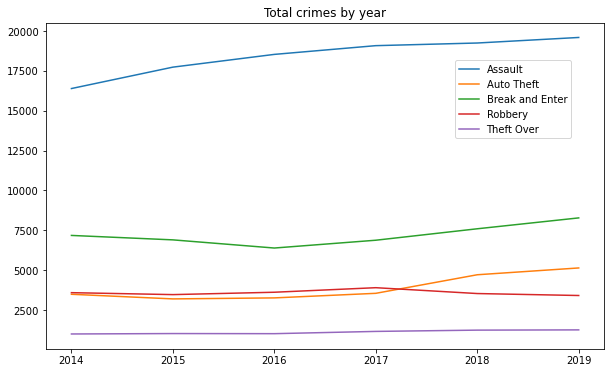

In [17]:
pd.crosstab(crime['occurrenceyear'],crime['MCI']).plot(figsize=(10,6))
plt.legend(loc='upper right', bbox_to_anchor=(0.95, 0.9))
plt.xlabel('')
plt.title('Total crimes by year')

#plt.savefig('total crimes by year.jpg', bbox_inches='tight');

Yearly trends indicate a sustained upward trend for Assaults, with the rest appearing almost stable. Let's break it down by month to see seasonality

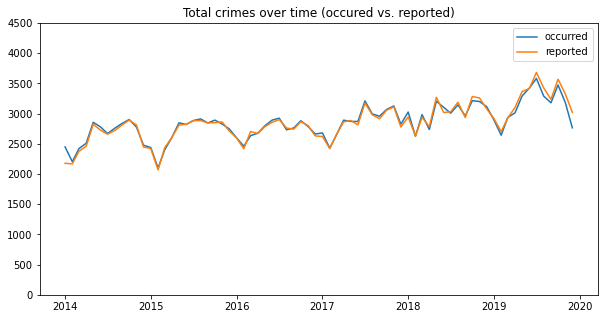

In [18]:
occurrence_month = crime.set_index(crime['occurrencedate'])
occurrence_month = occurrence_month['MCI']
reported_month = crime.set_index(crime['reporteddate'])
reported_month = reported_month['MCI']
occurrence_crime = occurrence_month.resample('MS').count()
reported_crime = reported_month.resample('MS').count()
fix, ax = plt.subplots(figsize=(10,5))
ax.plot(occurrence_crime, label='occurred')
ax.plot(reported_crime, label='reported')
ax.xaxis.set_label_text("")
ax.set_title('Total crimes over time (occured vs. reported)')
ax.set_yticks(np.arange(0, 5000, 500))
ax.legend()

#plt.savefig('occurred vs reported.jpg', bbox_inches='tight');

Seasonality shows peaks during summer months (May to Sep YOY) and bottoms at the cold months (Oct to Feb YOY). There is a slight difference between reporting and occurence times indicating delays in reporting crimes. We should look at that later.

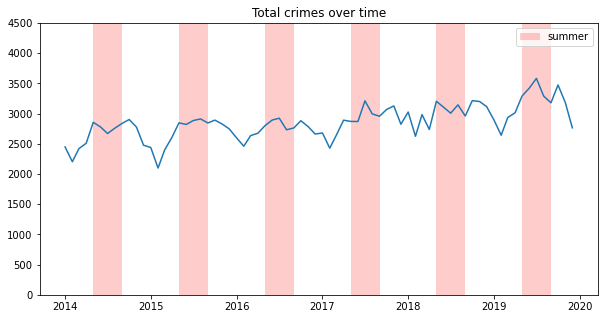

In [19]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(occurrence_crime)
ax.xaxis.set_label_text("")
ax.set_title('Total crimes over time')
ax.set_yticks(np.arange(0, 5000, 500))
a = occurrence_crime.index
x = [i for i in a if i.month == 5]
y = [j for j in a if j.month == 9]

for i in x:
    for j in y:
        if i.year == j.year and i.year == 2014:
            ax.axvspan(i, j, color='red', alpha=0.2, lw=0, label='summer')
        elif i.year == j.year:
            ax.axvspan(i, j, color='red', alpha=0.2, lw=0)
ax.legend();

#plt.savefig('total crimes over time.jpg', bbox_inches='tight');

Text(0.5, 1.0, 'Total crimes per category, by month')

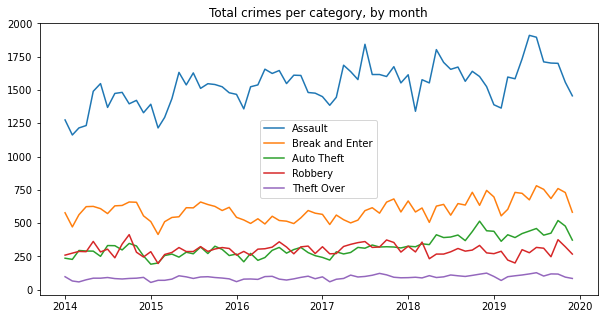

In [20]:
ts_month_frame = occurrence_month.to_frame()
tsf = ts_month_frame.groupby('MCI').resample('MS').count()
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(tsf.loc['Assault'], label='Assault')
ax.plot(tsf.loc['Break and Enter'], label='Break and Enter')
ax.plot(tsf.loc['Auto Theft'], label='Auto Theft')
ax.plot(tsf.loc['Robbery'], label='Robbery')
ax.plot(tsf.loc['Theft Over'], label='Theft Over')
ax.legend(loc='center')
ax.set_title('Total crimes per category, by month')

#plt.savefig('Total crimes per category, by month.jpg', bbox_inches='tight');

All crimes exhibit similar seasonalities, but only Assault has the clear upward trend.

Now let's see what a typical year looks like, crime-wise.

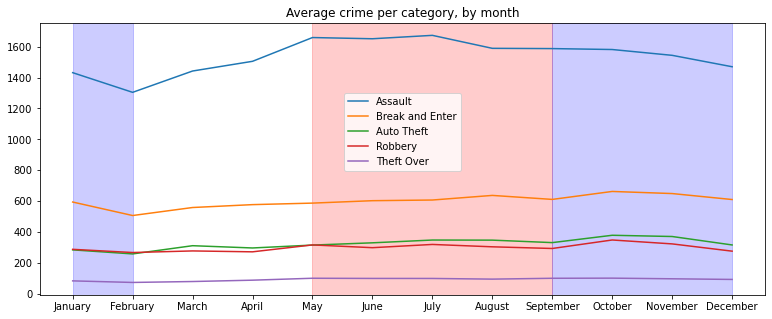

In [21]:
month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', \
    'November', 'December']
crime['occurrencemonth'] = pd.Categorical(crime['occurrencemonth'], categories=month)
crime_month_year = crime[['MCI', 'occurrenceyear', 'occurrencemonth', 'ObjectId']].groupby(\
    ['MCI', 'occurrenceyear', 'occurrencemonth'], as_index=False).count()
crime_year = pd.crosstab(crime_month_year['MCI'], crime_month_year['occurrencemonth'], aggfunc='mean', \
    values=crime_month_year['ObjectId'])
fig,ax = plt.subplots(figsize=(13,5))
ax.plot(month, crime_year.loc['Assault'], label='Assault')
ax.plot(month, crime_year.loc['Break and Enter'], label='Break and Enter')
ax.plot(month, crime_year.loc['Auto Theft'], label='Auto Theft')
ax.plot(month, crime_year.loc['Robbery'], label='Robbery') 
ax.plot(month, crime_year.loc['Theft Over'], label='Theft Over')
ax.legend(loc='center', bbox_to_anchor=(0.5, 0.6))
ax.set_title('Average crime per category, by month')
ax.axvspan('May', 'September', color='red', alpha=0.2)
ax.axvspan('January', 'February', color='blue', alpha=0.2)
ax.axvspan('September', 'December', color='blue', alpha=0.2)

#plt.savefig('Average crime per category, by month.jpg', bbox_inches='tight');

Average monthly crime trend is similar to the monthly breakdown trend, proving that seasonality is maintained year on year.  

Now let's see criminal activity within the hours of an average week.

Text(114.0, 0.5, '')

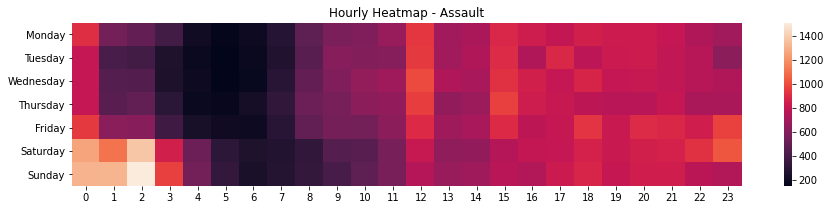

In [22]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
crime['occurrencedayofweek'] = pd.Categorical(crime['occurrencedayofweek'], categories=weekdays)

a = crime[crime['MCI'] == 'Assault']
a_hour = a.pivot_table(values='ObjectId',index='occurrencedayofweek',columns='occurrencehour',aggfunc="count")
fig, ax = plt.subplots(figsize=(15,3))  
ax = sns.heatmap(a_hour)
ax.set_title('Hourly Heatmap - Assault')
ax.xaxis.set_label_text("")
ax.yaxis.set_label_text("")

#plt.savefig('heat_assault.jpg', bbox_inches='tight');

Text(114.0, 0.5, '')

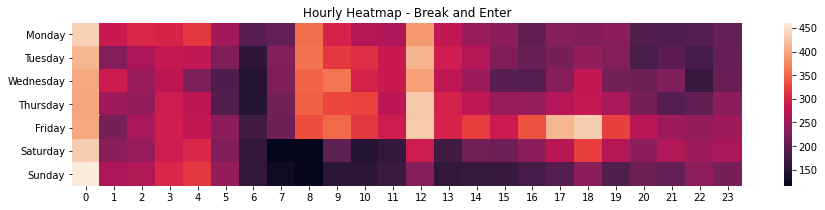

In [23]:
b = crime[crime['MCI'] == 'Break and Enter']
b_hour = b.pivot_table(values='ObjectId',index='occurrencedayofweek',columns='occurrencehour',aggfunc="count")
fig, ax = plt.subplots(figsize=(15,3))  
ax = sns.heatmap(b_hour)
ax.set_title('Hourly Heatmap - Break and Enter')
ax.xaxis.set_label_text("")
ax.yaxis.set_label_text("")

#plt.savefig('heat_bne.jpg', bbox_inches='tight');

Text(114.0, 0.5, '')

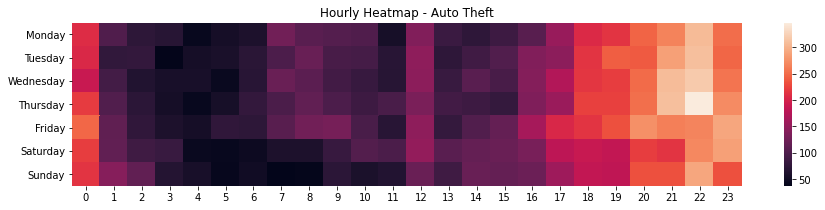

In [24]:
c = crime[crime['MCI'] == 'Auto Theft']
c_hour = c.pivot_table(values='ObjectId',index='occurrencedayofweek',columns='occurrencehour',aggfunc="count")
fig, ax = plt.subplots(figsize=(15,3))  
ax = sns.heatmap(c_hour)
ax.set_title('Hourly Heatmap - Auto Theft')
ax.xaxis.set_label_text("")
ax.yaxis.set_label_text("")

#plt.savefig('heat_autheft.jpg', bbox_inches='tight');

Text(114.0, 0.5, '')

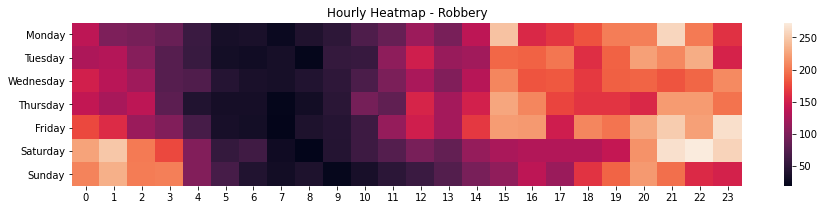

In [25]:
d = crime[crime['MCI'] == 'Robbery']
d_hour = d.pivot_table(values='ObjectId',index='occurrencedayofweek',columns='occurrencehour',aggfunc="count")
fig, ax = plt.subplots(figsize=(15,3))  
ax = sns.heatmap(d_hour)
ax.set_title('Hourly Heatmap - Robbery')
ax.xaxis.set_label_text("")
ax.yaxis.set_label_text("")

#plt.savefig('heat_rob.jpg', bbox_inches='tight');

Text(114.0, 0.5, '')

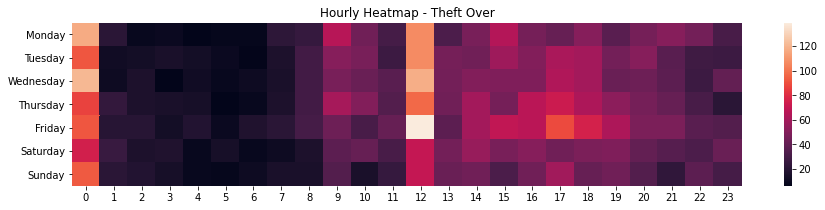

In [26]:
e = crime[crime['MCI'] == 'Theft Over']
e_hour = e.pivot_table(values='ObjectId',index='occurrencedayofweek',columns='occurrencehour',aggfunc="count")
fig, ax = plt.subplots(figsize=(15,3))  
ax = sns.heatmap(e_hour)
ax.set_title('Hourly Heatmap - Theft Over')
ax.xaxis.set_label_text("")
ax.yaxis.set_label_text("")

#plt.savefig('heat_thefto.jpg', bbox_inches='tight');

Text(114.0, 0.5, '')

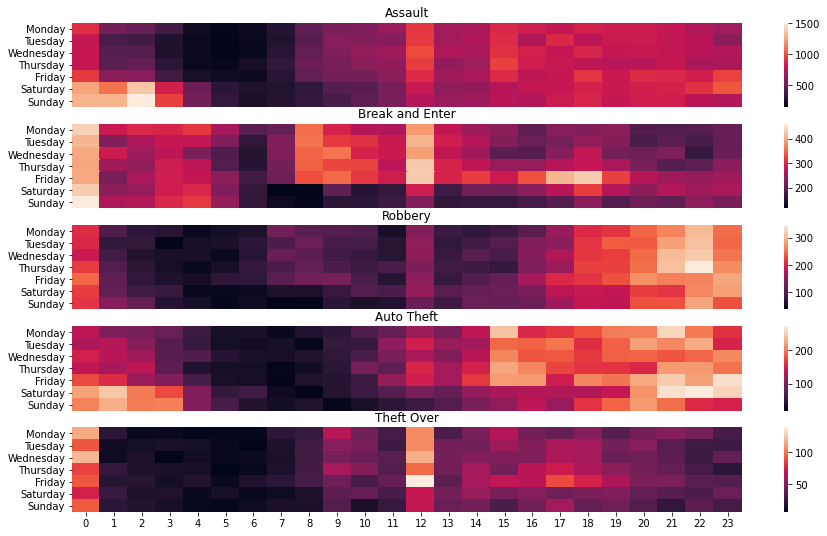

In [27]:
f,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, sharex=True, sharey=True, figsize=(15,9))

ax1 = sns.heatmap(a_hour, ax=ax1)
ax2 = sns.heatmap(b_hour, ax=ax2)
ax3 = sns.heatmap(c_hour, ax=ax3)
ax4 = sns.heatmap(d_hour, ax=ax4)
ax5 = sns.heatmap(e_hour, ax=ax5)
ax1.set_title('Assault')
ax1.xaxis.set_label_text("")
ax1.yaxis.set_label_text("")
ax1.tick_params(axis='x', bottom=False)
ax2.set_title('Break and Enter')
ax2.xaxis.set_label_text("")
ax2.yaxis.set_label_text("")
ax2.tick_params(axis='x', bottom=False)
ax3.set_title('Robbery')
ax3.xaxis.set_label_text("")
ax3.yaxis.set_label_text("")
ax3.tick_params(axis='x', bottom=False)
ax4.set_title('Auto Theft')
ax4.xaxis.set_label_text("")
ax4.yaxis.set_label_text("")
ax4.tick_params(axis='x', bottom=False)
ax5.set_title('Theft Over')
ax5.xaxis.set_label_text("")
ax5.yaxis.set_label_text("")

#plt.savefig('heat_mci.jpg', bbox_inches='tight');

All heatmaps share a few commonalities  
* Crime is hot during noon and midnight, and during night time
* `Assault` and `Auto Theft` have similar past-midnight heat trends, especially during weekends
* `BnEs` have consistent heat allthroughout the week

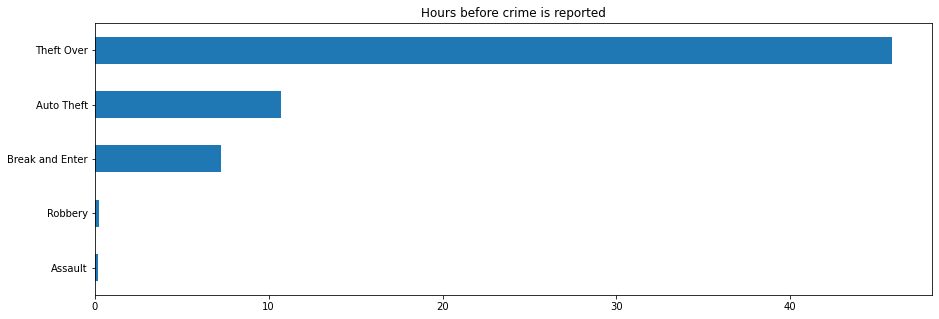

In [28]:
crime['report_time'] = crime['reporteddate'] - crime['occurrencedate']
MCI_time = crime[['MCI', 'report_time']].groupby(['MCI']).median(numeric_only=False).sort_values('report_time', ascending=True)
MCI_time['report_time_hrs'] = MCI_time['report_time'] / np.timedelta64(1, 'h')
MCI_time = MCI_time.drop(['report_time'], axis=1)
MCI_time.plot(kind='barh', figsize=(15,5))
plt.xlabel('')
plt.ylabel('')
plt.title('Hours before crime is reported')
plt.legend('', frameon=False);

#plt.savefig('report_time.jpg', bbox_inches='tight');

In [29]:
MCI_times = crime[['MCI', 'report_time']].groupby(['MCI']).median(numeric_only=False)
MCI_times['Total'] = crime[['MCI']].groupby('MCI').size()
MCI_times.sort_values('Total',ascending=False)

,report_time,Total
MCI,,
Assault,0 days 00:11:00,110609
Break and Enter,0 days 07:16:00,43214
Auto Theft,0 days 10:42:00,23330
Robbery,0 days 00:13:00,21500
Theft Over,1 days 21:50:30,6668


In [30]:
offence_time = crime[['offence', 'report_time']].groupby(['offence']).median(numeric_only=False)
offence_time['total'] = crime[['offence']].groupby('offence').size()
offence_time.sort_values(by='report_time',ascending=False)

,report_time,total
offence,,
Theft - Misapprop Funds Over,19 days 05:59:00,19
Theft Over,3 days 15:23:00,3808
Theft From Mail / Bag / Key,2 days 17:39:30,688
Theft Over - Bicycle,1 days 05:00:00,89
Theft From Motor Vehicle Over,0 days 19:48:00,1588
B&E - M/Veh To Steal Firearm,0 days 15:17:30,8
B&E Out,0 days 12:35:00,76
Theft Of Motor Vehicle,0 days 10:42:00,23330
B&E,0 days 07:50:00,36235


Thefts take time to notice, hence the hours/days duration. Violent crimes take about 10 minutes to report.  

Now let's look at location data.

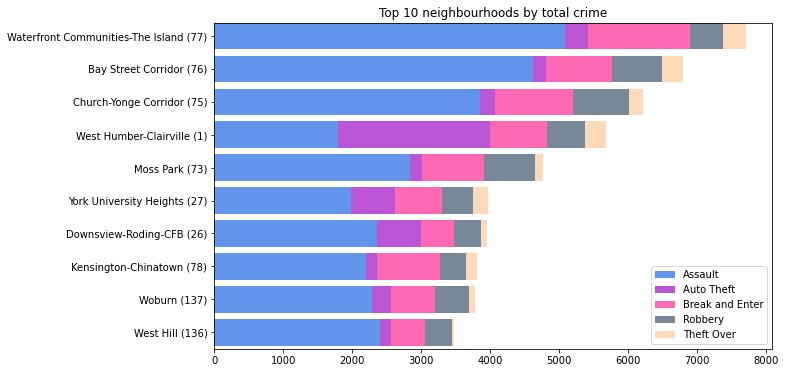

In [31]:
total = crime.pivot_table(values='ObjectId',index='Neighbourhood',columns='MCI',aggfunc="count")
total['Total'] = total['Assault'] + total['Auto Theft'] + total['Break and Enter'] + total['Robbery'] + total['Theft Over']
total = total.sort_values('Total', ascending=True).reset_index()

f,ax = plt.subplots(figsize=(10,6))
y_ax = total['Neighbourhood']
a = total['Assault']
b = total['Auto Theft']
c = total['Break and Enter']
d = total['Robbery']
e = total['Theft Over']
plt.barh(y_ax, a, color='cornflowerblue', label='Assault')
plt.barh(y_ax, b, color='mediumorchid', left=a, label='Auto Theft')
plt.barh(y_ax, c, color='hotpink', left=list(map(lambda v,w: v+w, a,b)), label='Break and Enter')
plt.barh(y_ax, d, color='lightslategrey', left=list(map(lambda v,w,x: v+w+x, a,b,c)), label='Robbery')
plt.barh(y_ax, e, color='peachpuff', left=list(map(lambda v,w,x,y: v+w+x+y, a,b,c,d)), label='Theft Over') 
plt.margins(y=0)
ax.set_ylim(bottom=(len(y_ax)-10.5))
#ax.grid(axis='x')
ax.set_title('Top 10 neighbourhoods by total crime')
ax.legend(ncol=1, loc="lower right", frameon=True)
plt.savefig('top10hood.jpg', bbox_inches='tight');

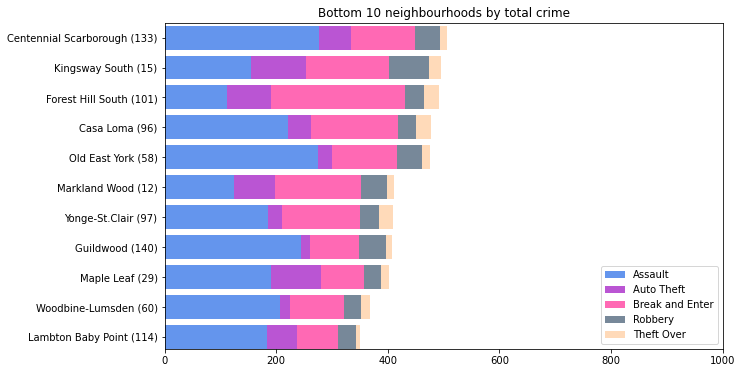

In [32]:
f,ax = plt.subplots(figsize=(10,6))
plt.barh(y_ax, a, color='cornflowerblue', label='Assault')
plt.barh(y_ax, b, color='mediumorchid', left=a, label='Auto Theft')
plt.barh(y_ax, c, color='hotpink', left=list(map(lambda v,w: v+w, a,b)), label='Break and Enter')
plt.barh(y_ax, d, color='lightslategrey', left=list(map(lambda v,w,x: v+w+x, a,b,c)), label='Robbery')
plt.barh(y_ax, e, color='peachpuff', left=list(map(lambda v,w,x,y: v+w+x+y, a,b,c,d)), label='Theft Over') 
plt.margins(y=0)
ax.set_ylim(top=10.5)
ax.set_xlim(0, 1000)
#ax.grid(axis='x')
ax.set_title('Bottom 10 neighbourhoods by total crime')
ax.legend(ncol=1, loc="lower right", frameon=True)
plt.savefig('bot10hoods.jpg', bbox_inches='tight');

Downtown Toronto comprise the top 3 neighborhoods by total crime. It might have to do with population density.  

Interestingly, most Auto Thefts are in West Humber -  Clairville.

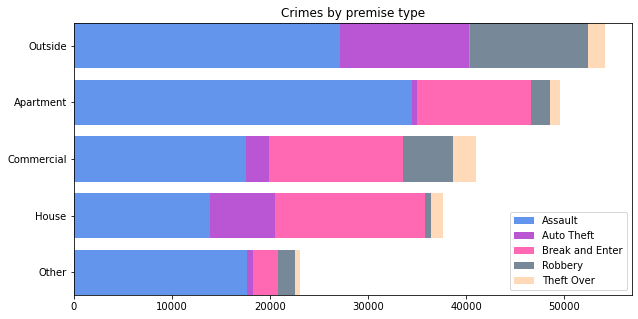

In [33]:
total = crime.pivot_table(values='ObjectId',index='premisetype',columns='MCI',aggfunc="count")
total['Total'] = total['Assault'] + total['Auto Theft'] + total['Break and Enter'] + total['Robbery'] + total['Theft Over']
total = total.sort_values('Total', ascending=True).reset_index()

f,ax = plt.subplots(figsize=(10,5))
y_ax = total['premisetype']
a = total['Assault']
b = total['Auto Theft']
c = total['Break and Enter']
d = total['Robbery']
e = total['Theft Over']
plt.barh(y_ax, a, color='cornflowerblue', label='Assault')
plt.barh(y_ax, b, color='mediumorchid', left=a, label='Auto Theft')
plt.barh(y_ax, c, color='hotpink', left=list(map(lambda v,w: v+w, a,b)), label='Break and Enter')
plt.barh(y_ax, d, color='lightslategrey', left=list(map(lambda v,w,x: v+w+x, a,b,c)), label='Robbery')
plt.barh(y_ax, e, color='peachpuff', left=list(map(lambda v,w,x,y: v+w+x+y, a,b,c,d)), label='Theft Over') 
plt.margins(y=0)
#ax.grid(axis='x')
ax.set_title('Crimes by premise type')
ax.legend(ncol=1, loc="lower right", frameon=True)
plt.savefig('premise.jpg', bbox_inches='tight');

Most crimes happen outside, as indicated by the top counts of Robberies, Auto Thefts and Assaults. Houses are top preference for BnEs.

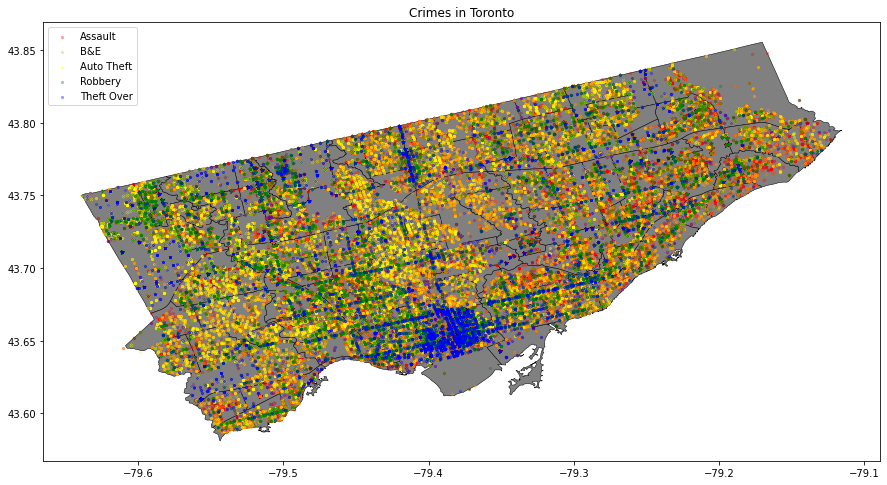

In [34]:
toronto = gpd.read_file('Neighbourhoods.shp')
crime_loc = [Point(xy) for xy in zip(crime['Long'], crime['Lat'])]
crime_space = gpd.GeoDataFrame(crime, geometry=crime_loc)
f,ax = plt.subplots(figsize=(15,15))
toronto.plot(ax=ax, color='gray', linewidth=0.5, edgecolor='k')
crime_space[crime_space['MCI']=='Assault'].plot(ax=ax, markersize=5, color='red', marker='o', label='Assault', alpha=0.3)
crime_space[crime_space['MCI']=='Break and Enter'].plot(ax=ax, markersize=5, color='orange', marker='o', label='B&E', alpha=0.3)
crime_space[crime_space['MCI']=='Auto Theft'].plot(ax=ax, markersize=5, color='yellow', marker='o', label='Auto Theft', alpha=0.3)
crime_space[crime_space['MCI']=='Robbery'].plot(ax=ax, markersize=5, color='green', marker='o', label='Robbery', alpha=0.3)
crime_space[crime_space['MCI']=='Theft Over'].plot(ax=ax, markersize=5, color='blue', marker='o', label='Theft Over', alpha=0.3)
ax.set_title('Crimes in Toronto')
ax.legend();
#plt.savefig('Crimes in TO.jpg', bbox_inches='tight');

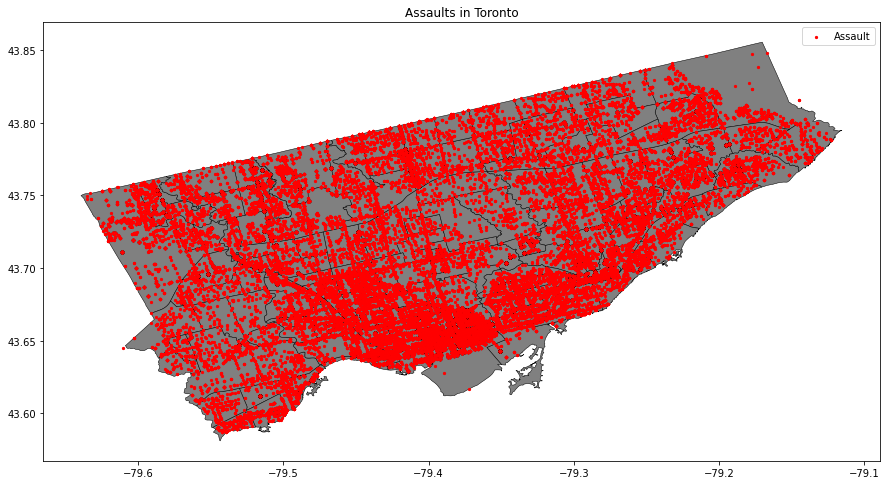

In [35]:
f,ax = plt.subplots(figsize=(15,15))
toronto.plot(ax=ax, color='gray', linewidth=0.5, edgecolor='k')
crime_space[(crime_space['MCI']=='Assault')].plot(ax=ax, markersize=5, color='red', marker='o', label='Assault')
#& (crime_space['occurrenceyear']==2019)
ax.set_title('Assaults in Toronto')
ax.legend();

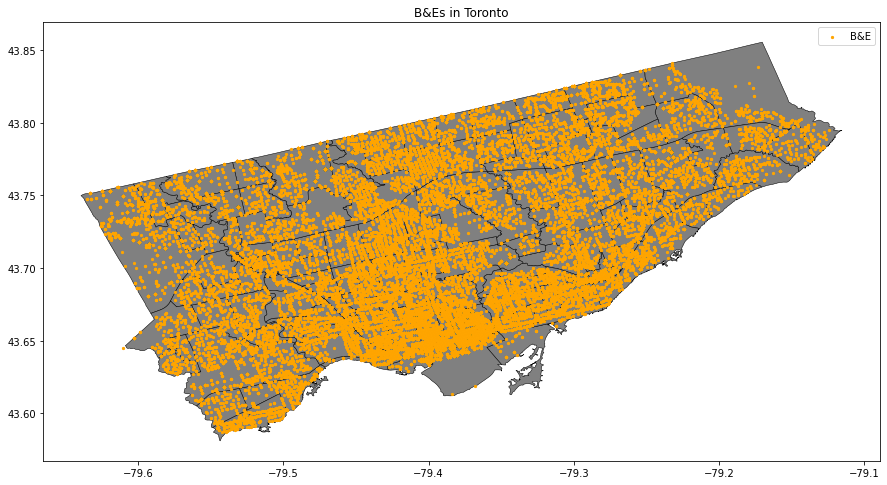

In [36]:
f,ax = plt.subplots(figsize=(15,15))
toronto.plot(ax=ax, color='gray', linewidth=0.5, edgecolor='k')
crime_space[crime_space['MCI']=='Break and Enter'].plot(ax=ax, markersize=5, color='orange', marker='o', label='B&E')
ax.set_title('B&Es in Toronto')
ax.legend();

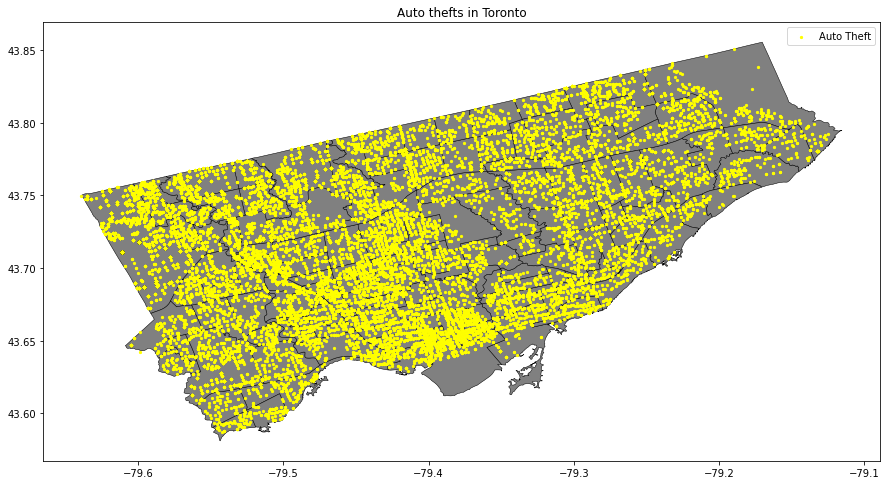

In [37]:
f,ax = plt.subplots(figsize=(15,15))
toronto.plot(ax=ax, color='gray', linewidth=0.5, edgecolor='k')
crime_space[crime_space['MCI']=='Auto Theft'].plot(ax=ax, markersize=5, color='yellow', marker='o', label='Auto Theft')
ax.set_title('Auto thefts in Toronto')
ax.legend();

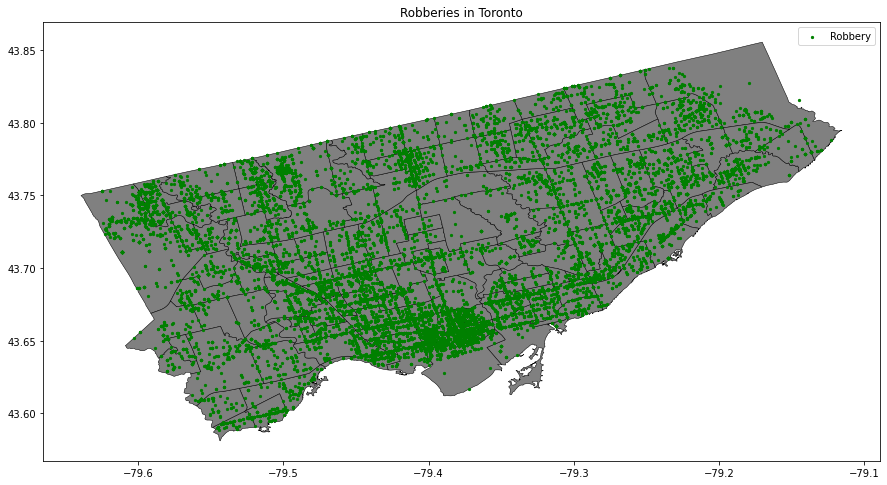

In [38]:
f,ax = plt.subplots(figsize=(15,15))
toronto.plot(ax=ax, color='gray', linewidth=0.5, edgecolor='k')
crime_space[crime_space['MCI']=='Robbery'].plot(ax=ax, markersize=5, color='green', marker='o', label='Robbery')
ax.set_title('Robberies in Toronto')
ax.legend();

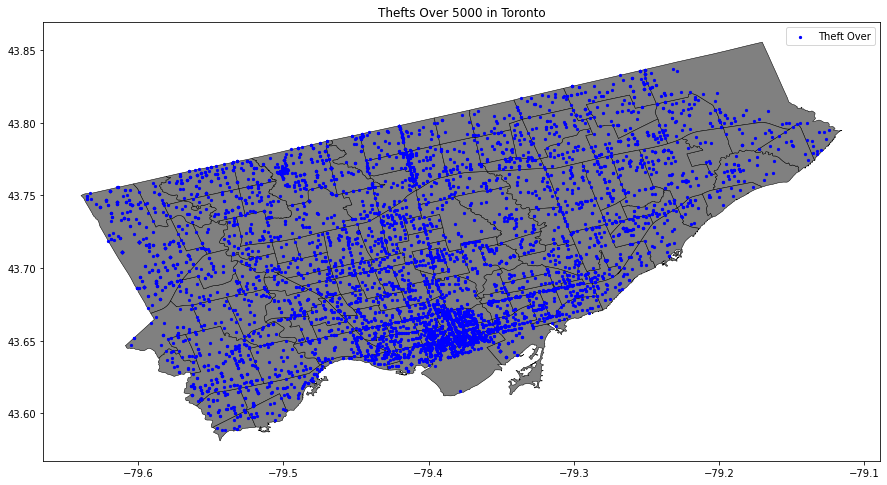

In [39]:
f,ax = plt.subplots(figsize=(15,15))
toronto.plot(ax=ax, color='gray', linewidth=0.5, edgecolor='k')
crime_space[crime_space['MCI']=='Theft Over'].plot(ax=ax, markersize=5, color='blue', marker='o', label='Theft Over')
ax.set_title('Thefts Over 5000 in Toronto')
ax.legend();

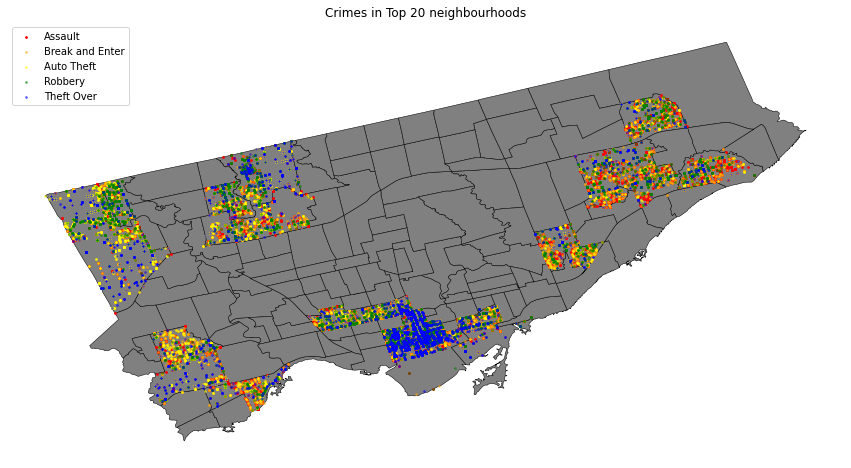

In [40]:
th = crime.pivot_table(values='ObjectId',index='Neighbourhood',columns='MCI',aggfunc="count")
th['Total'] = th['Assault'] + th['Auto Theft'] + th['Break and Enter'] + th['Robbery'] + th['Theft Over']
th20 = th.sort_values('Total', ascending=False).reset_index().head(20)
top_hood = crime.loc[crime['Neighbourhood'].isin(th20['Neighbourhood'])]
top_hood_loc = [Point(xy) for xy in zip(top_hood['Long'], top_hood['Lat'])]
crime_space = gpd.GeoDataFrame(top_hood, geometry=top_hood_loc)
a = crime_space[crime_space['MCI']=='Assault']
b = crime_space[crime_space['MCI']=='Break and Enter']
c = crime_space[crime_space['MCI']=='Auto Theft']
d = crime_space[crime_space['MCI']=='Robbery']
e = crime_space[crime_space['MCI']=='Theft Over']

f,ax = plt.subplots(figsize=(15,15))
toronto.plot(ax=ax, color='gray', linewidth=0.5, edgecolor='k')
a.plot(ax=ax, markersize=3, color='red', marker='o', label='Assault', alpha=1)
b.plot(ax=ax, markersize=3, color='orange', marker='o', label='Break and Enter', alpha=0.5)
c.plot(ax=ax, markersize=3, color='yellow', marker='o', label='Auto Theft', alpha=0.5)
d.plot(ax=ax, markersize=3, color='green', marker='o', label='Robbery', alpha=0.5)
e.plot(ax=ax, markersize=3, color='blue', marker='o', label='Theft Over', alpha=0.5)
ax.set_title('Crimes in Top 20 neighbourhoods')
ax.legend(loc='upper left', frameon=True)
ax.axis('off');
#plt.savefig('Crimes in top TO hoods.jpg', bbox_inches='tight');

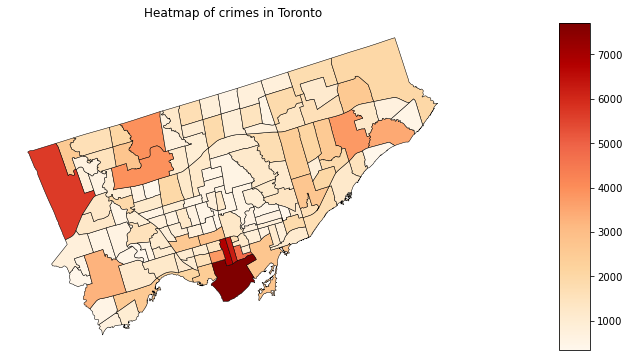

In [41]:
toronto_crime = pd.merge(toronto, th, how='inner', left_on='FIELD_7', right_on='Neighbourhood')

from mpl_toolkits.axes_grid1 import make_axes_locatable

f,ax = plt.subplots(figsize=(12,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
toronto_crime.plot(column='Total', linewidth=0.5, edgecolor='k', cmap='OrRd', ax=ax, legend=True, cax=cax)
ax.set_title('Heatmap of crimes in Toronto')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis='both', bottom=False, left=False)
ax.axis('off');
#plt.savefig('Heatmap TO crimes.jpg', bbox_inches='tight');

The maps shown above show heavy density on the downtown areas. Based on the heatmap, a quick runner-up to downtown areas is `West Humber - Claireville` on the top left. It's where most `Auto Thefts` occur.

In [42]:
toronto_crime.head()

,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_7,FIELD_8,FIELD_9,FIELD_10,...,FIELD_13,FIELD_14,FIELD_15,geometry,Assault,Auto Theft,Break and Enter,Robbery,Theft Over,Total
0,4481,25886861,25926662,49885,94,94,Wychwood (94),Wychwood (94),None,None,...,16491505,3.217960e+06,7515.779658,"POLYGON ((-79.43592 43.68015, -79.43492 43.680...",421,79,204,83,13,800
1,4482,25886820,25926663,49885,100,100,Yonge-Eglinton (100),Yonge-Eglinton (100),None,None,...,16491521,3.160334e+06,7872.021074,"POLYGON ((-79.41096 43.70408, -79.40962 43.704...",453,54,168,117,28,820
2,4483,25886834,25926664,49885,97,97,Yonge-St.Clair (97),Yonge-St.Clair (97),None,None,...,16491537,2.222464e+06,8130.411276,"POLYGON ((-79.39119 43.68108, -79.39141 43.680...",185,26,140,34,24,409
3,4484,25886593,25926665,49885,27,27,York University Heights (27),York University Heights (27),None,None,...,16491553,2.541821e+07,25632.335242,"POLYGON ((-79.50529 43.75987, -79.50488 43.759...",1983,633,679,455,217,3967
4,4485,25886688,25926666,49885,31,31,Yorkdale-Glen Park (31),Yorkdale-Glen Park (31),None,None,...,16491569,1.156669e+07,13953.408098,"POLYGON ((-79.43969 43.70561, -79.44011 43.705...",952,332,377,189,135,1985
